In [1]:
import os as os
import sys as sys
import subprocess
#import k2
import subprocess
import matplotlib.pyplot as plt
from matplotlib import*
import numpy as np
#import libcarma as libcarma
import time as time
import copy as copy
import math as math
import cmath as cmath
import psutil as psutil
import pandas
%matplotlib inline

In [2]:
import pandas

cols = ['cadence', 'mask', 't', 'x', 'y', 'yerr']


In [3]:
import seaborn as sns
sns.set_palette("colorblind")
sns.set_style("white")
def plotlc(t,y,mask,name):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t,y*mask, marker = '+',label=name)
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Flux')
    ax.legend(loc="upper right", fontsize=18,markerscale=0) 


    #ax.set_xlim(0, 6*np.pi)

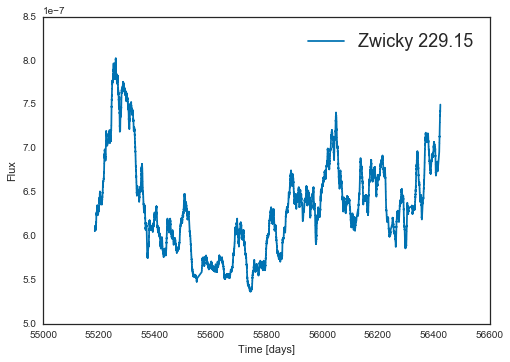

In [4]:
zwick = np.loadtxt('iizw229015_kepler_q04_q17.csv',delimiter=',')
zcols = [ 't', 'cadence', 'y', 'yerr']
zwickdata = pandas.DataFrame(data=zwick,columns=zcols, dtype=float)
zwickplot = plotlc(zwickdata['t'],zwickdata['y'],mask=1, name = 'Zwicky 229.15')
plt.savefig('zwick.png')

# This function pulls a random slice of the lightcurve in a fixed 80 window
This will test what information we can get out of the k2 time window.

2400
55524


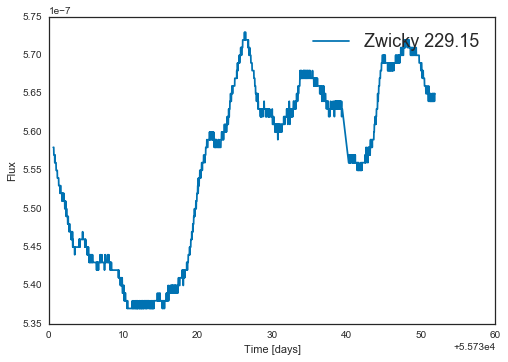

In [18]:
#chop up lightcurve, re-fit small segments, compare precision in values, is model order correct, look for evidence of nesting

def chop(data):
    start = np.random.randint(0, high=len(data)-80*30)
    stop = int(80*30)
    print stop
    print len(data)
    sliceofpi = data.loc[start:start+stop]
    return sliceofpi
pi = chop(zwickdata)
piplot = plotlc(pi['t'],pi['y'],mask=1, name = 'Zwicky 229.15')
plt.savefig('zwick_chunk.png')    

# This is a regular cadence down sampler
we have set the test to be function of the damped harmonic oscillator frequency provided by the best fit CARMA(2,1) model

In [38]:
#assuming a harmoninc oscillator period T = 60 days for 2,1 best fit model to Zwicky 229.15. 
# we test for how much data do we need with a regular cadence for full length lightcurve.
# do we lose precision? can we see evidence of nested model fits
#how does this compare with irregular cadences as we increase sparsity between observations

def reg_sampler(zwickdata):
    oscillatorP = 60
    time = zwickdata['t']
    length = time.iloc[-1] - time.iloc[0]
    #this length of 3.4 years captures about 20 cycles, this length is appropriate for this cadence study
    #69 also happens to be the dampening timescale for this over damped system, so it is also well constrained 
    cycles = length/oscillatorP
    freq1 = 10 * cycles
    freq2 = 20 * cycles
    freq3 = 50 * cycles
    freq4 = 100 * cycles

    sampRate1= np.floor(len(zwickdata)/freq1)
    ones = np.arange(0,len(zwickdata),sampRate1,dtype=int)
    mask = np.zeros(len(zwickdata))
    mask[ones] = 1.0
    print("Number of points in the lightcurve")
    print(len(ones))
    return ones, mask
ones, mask = reg_sampler(zwickdata)    

Number of points in the lightcurve
208


In [79]:
def reg_sampler(df, ocillatorP, N=10):
	zwickdata = df
	oscillatorP = 60
	time = zwickdata['t']
	length = time.iloc[-1] - time.iloc[0]
	cycles = length/oscillatorP
	freq1 = N * cycles
	sampRate1= np.floor(len(zwickdata)/freq1)
	ones = np.arange(0,len(zwickdata),sampRate1,dtype=int)
	newdf = zwickdata.iloc[ones]
	print("Number of points in the lightcurve")
	print(len(newdf))
	#return np.require(newdf.as_matrix(newdf.columns), requirements=['F', 'A', 'W', 'O', 'E'])    
	return ones
ones = reg_sampler(zwickdata,60,10)        

Number of points in the lightcurve
208


In [27]:
def irreg_sampler(df, ocillatorP, N):
	zwickdata = df
	oscillatorP = 60 #units = days
	time = zwickdata['t']
	length = time.iloc[-1] - time.iloc[0]
	cycles = np.floor(length/oscillatorP)
	freq1 = N * cycles
	newdf = zwickdata.sample(freq1)
	newdf = newdf.sort_values(['t'])
	#newdf = zwickdata.iloc[ones]
	print("Number of points in the lightcurve")
	print(len(newdf))
	return newdf#return np.require(newdf.as_matrix(newdf.columns), requirements=['F', 'A', 'W', 'O', 'E'])    	

Number of points in the lightcurve
200


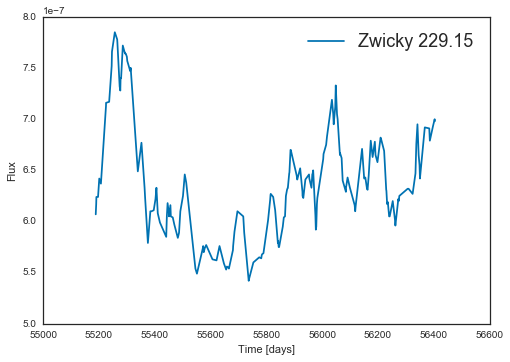

In [29]:
newdf = irreg_sampler(zwickdata,60,10) 
#newdf
zwickplot = plotlc(newdf['t'],newdf['y'],mask=1, name = 'Zwicky 229.15')
plt.savefig('zwick20.png')

In [60]:

def smart_irreg_sampler(df, ocillatorP, N):
	zwickdata = df
	oscillatorP = 60 #units = days
	time = zwickdata['t']
	length = time.iloc[-1] - time.iloc[0]
	cycles = np.floor(length/oscillatorP)
	sampRate1= np.floor(len(zwickdata)/cycles)
	ones = np.arange(0,len(zwickdata),sampRate1,dtype=int)
	sample = np.array([])
	constraint = np.random.randint(8, 12)
	for i in range(0,len(ones)-1):
		dummy = np.arange(ones[i],ones[i+1],1,dtype=int)  
		np.random.shuffle(dummy)
		dummy2 = dummy[:constraint]
		sample = np.append(sample,dummy2)
	sample = sample.astype(int)    
	newdf = zwickdata.iloc[sample]
	newdf = newdf.sort_values(['t'])

	print("Number of points in the lightcurve")
	print(len(newdf))
	return newdf#return np.require(newdf.as_matrix(newdf.columns), requirements=['F', 'A', 'W', 'O', 'E']) 

Number of points in the lightcurve
180


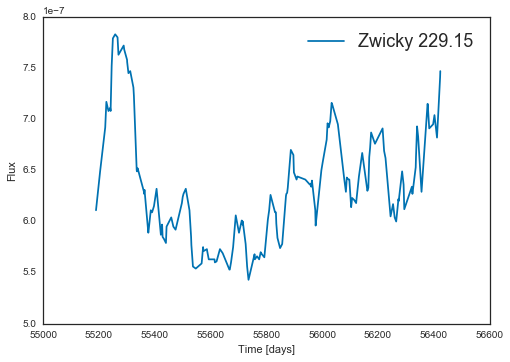

In [61]:
newdf = smart_irreg_sampler(zwickdata,60,10) 
#newdf
zwickplot = plotlc(newdf['t'],newdf['y'],mask=1, name = 'Zwicky 229.15')
plt.savefig('zwick20.png')

# This plot shows the down sampled lightcurve from ~60,000 points to 200 points (10 observations per cycle)
Very little structure appears to be lost by eye.  Before we re-fit, our hypothesis is that if aliasing is happening on high frequency variability that is below the nykvist frequency, that will manifest as a low frequency parameter in the model.  The aliased feature will appear as something in a low frequency band in the power spectrum.  

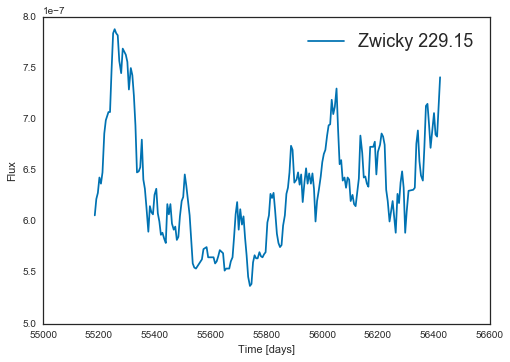

In [81]:
zwickplot = plotlc(zwickdata['t'].iloc[ones],zwickdata['y'].iloc[ones],mask=1, name = 'Zwicky 229.15')
plt.savefig('zwick20.png')

# Irregular down-sampler
In principle this should not produce aliasing as long as the lightcurve length resolves many cycles

In [42]:
def irreg_sampler(zwickdata):
    oscillatorP = 60
    time = zwickdata['t']
    length = time.iloc[-1] - time.iloc[0]
    #this length of 3.4 years captures about 20 cycles, this length is appropriate for this cadence study
    #69 also happens to be the dampening timescale for this over damped system, so it is also well constrained 
    cycles = length/oscillatorP
    freq1 = 10 * cycles
    freq2 = 20 * cycles
    freq3 = 50 * cycles
    freq4 = 100 * cycles

    ones = np.sort(np.random.randint(0, high=len(zwickdata), size=freq1))

    mask = np.zeros(len(zwickdata))
    mask[ones] = 1.0
    print("Number of points in the lightcurve")
    print(len(ones))
    return ones, mask
ones, mask = irreg_sampler(zwickdata)    

Number of points in the lightcurve
206


/Users/Jackster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


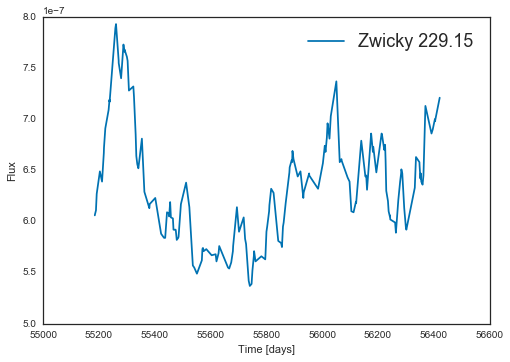

In [43]:
zwickplot = plotlc(zwickdata['t'].iloc[ones],zwickdata['y'].iloc[ones],mask=1, name = 'Zwicky 229.15')

Make nt.chains into data frame to plot with seaborn